# Establishing a Baseline for Vendor Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
df = pd.read_csv('iowa_liquor.csv')

In [10]:
df=df.loc[~df.vendor_name.isnull()]

In [13]:
vendor = df.loc[df.vendor_name.str.contains('DIAGEO AMERICAS')]

In [14]:
vendor['date']= pd.to_datetime(vendor.date)
vendor['week']= vendor.date.dt.week
vendor['month']=vendor.date.dt.month

C:\Users\Owner\Python_Install\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Owner\Python_Install\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Owner\Python_Install\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [22]:
# forecasting total units for Diageo Americas
base = pd.DataFrame(vendor.groupby('date').item_description.count()).reset_index()

In [23]:
# working with Jan 1, 2018 to July 31, 2019
base.date.min()
base.date.max()

Timestamp('2018-01-02 00:00:00')

# Naive Forecasting Method

Naive forecasting assumes that the previous period's demand is going to be the next period's demand. It is mathematically written as:
    y^t+h|t=yt
Where y-hat to our predicted variable. We are predicting y-hat while taking into account all info up to time t. Subscript h indicates the number of time steps. 

Naive forecasting simply takes the value from the most recent period and forecasts it foreward. 

In [96]:
n = len(base)
train_count = round(n*0.75) # training on 75% of data
train = base.iloc[:train_count] # not randomly selecting. Forecasting involves training on sequential data
test= base.iloc[train_count +1:n]

In [97]:
base.rename(columns={'item_description': 'order_count'}, inplace=True)

In [47]:
y_hat = test.copy().drop('order_count', axis=1)
y_hat['date']=y_hat['date']+nptimedelta64(1,"D")


In [49]:
y_hat.head()

,date
305,2019-03-14
306,2019-03-15
307,2019-03-18
308,2019-03-19
309,2019-03-20


In [51]:
y_hat['date']=y_hat['date']+np.timedelta64(1,"D")

In [54]:
y_hat['naive']=train.loc[len(train)-1,'order_count']

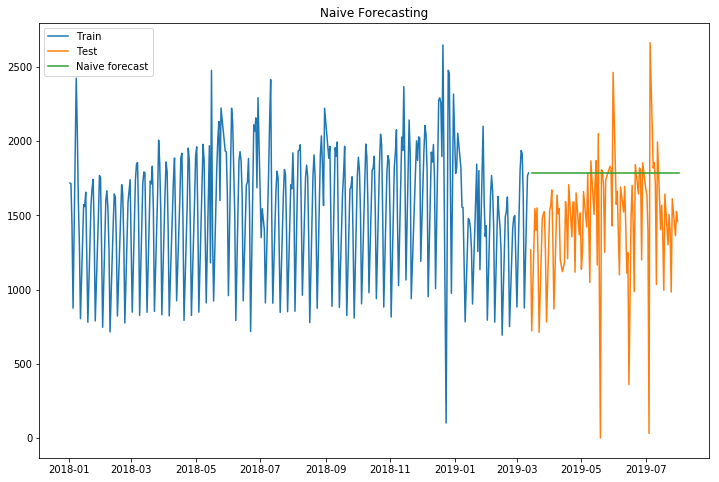

In [59]:
plt.figure(figsize=(12,8))

plt.plot(train['date'], train['order_count'], label='Train')
plt.plot(test['date'], test['order_count'], label='Test')
plt.plot(y_hat['date'], y_hat['naive'], label='Naive forecast')

plt.legend(loc='best')
plt.title('Naive Forecasting')
plt.show();

### Evaluating the basic forecast

In [64]:
evaluate = pd.merge(test,y_hat, on='date')
evaluate.volumns=['date','order_count','naive']
evaluate['error'] = evaluate['order_count']-evaluate['naive']

C:\Users\Owner\Python_Install\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [66]:
evaluate.insert(0,'series',1) #inserting a value to groupby

In [69]:
evaluate.groupby('series').agg({
    'order_count': 'sum',
    'naive': 'sum',
    'error': {
        'total_error': 'sum',
        'mae': lambda x: np.mean(np.abs(x)),
        'rmse': lambda x: np.sqrt(np.mean(x**2)),
        'mape': lambda x: 100 * np.sum(np.abs(x))/np.sum(evaluate['order_count'])
    }
})

C:\Users\Owner\Python_Install\lib\site-packages\pandas\core\groupby\groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


order_count   naive       error                                   
               sum     sum total_error         mae        rmse       mape
series                                                                   
1           115375  141015      -25640  387.670886  515.243189  26.544745

In [71]:
# MAE and RMSE are scale dependent metrics, so they are incomparable to other scales. 
# RMSE punishes large forecasting errors more because of the squaring
# MAPE is scale independent, since it's based off of percentages.
# 0 must be meaningful for MAPE to be reliable
# consider using the weighted MAPE so that you're able to punish more for mistakes with higher margin products (ex)

# Seasonal Naive

In [98]:
dates = (test['date']-np.timedelta64(1,"Y")).values.astype('datetime64[D]')

In [136]:
seasonal_naive = train[train['date'].isin(dates)==True][['date','order_count']] #prediction
#sn_dates = train[train['date'].isin(dates)==True]['date']

In [ ]:
seasonal_naive['date'] = seasonal_naive['date'] + np.timedelta64(1,"Y")

In [180]:
y_hat_sn = test.copy().drop('order_count', axis=1)

In [ ]:
seasonal_naive['date']=seasonal_naive.date.dt.date

In [187]:
used_dates = seasonal_naive['date']

In [145]:
#sn_prediction = seasonal_naive.merge(y_hat_sn, how='left', on='date')

In [188]:
y_hat_sn = y_hat_sn[y_hat_sn['date'].isin(used_dates)]

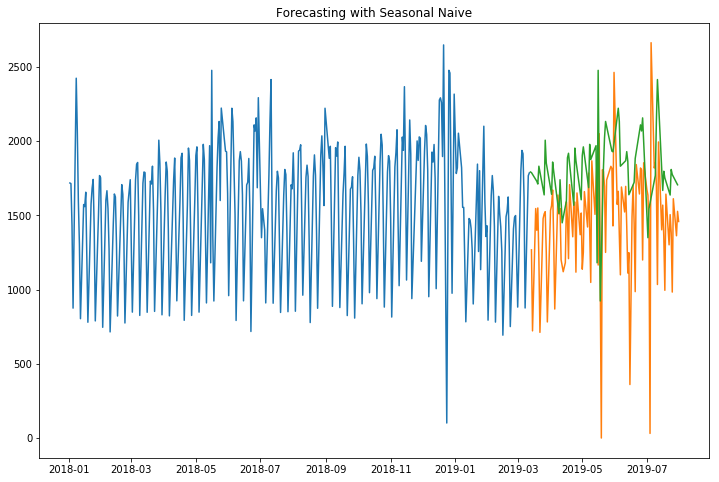

In [196]:
plt.figure(figsize=(12,8))

plt.plot(train['date'], train['order_count'], label='Train')
plt.plot(test['date'], test['order_count'], label='Test')
plt.plot(seasonal_naive['date'],seasonal_naive['order_count'], label='Seasonal Naive Forecast')
#plt.legend(loc='best') accidentally overwrote
plt.title('Forecasting with Seasonal Naive')
plt.show();

#### Evaluating

In [199]:
test['date'] = pd.to_datetime(test.date)
seasonal_naive['date'] = pd.to_datetime(seasonal_naive.date)
evaluation = pd.merge(test,seasonal_naive, on='date')

C:\Users\Owner\Python_Install\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [205]:
evaluation.rename(columns={'order_count_y': 'naive', 'order_count_x':'order_count'}, inplace=True)


In [206]:
evaluation.colums=['date','order_count','naive']
evaluation['error']  = evaluation['order_count'] -evaluation['naive']
evaluation.insert(0,'series',1) # groupby value

In [207]:
evaluation.groupby('series').agg({
    'order_count': 'sum',
    'naive':'sum',
    'error': {
        'total_error': 'sum',
        'mae': lambda x: np.mean(np.abs(x)),
        'rmse': lambda x: np.sqrt(np.mean(x**2)),
        'mape': lambda x: 100* np.sum(np.abs(x))/np.sum(evaluation['order_count'])
    }
})

C:\Users\Owner\Python_Install\lib\site-packages\pandas\core\groupby\groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


order_count   naive       error                                   
               sum     sum total_error         mae        rmse       mape
series                                                                   
1            82281  104791      -22510  436.280702  542.416102  30.223259

In [ ]:
# The seasonal forecast performs WORSE than the naive forecast